In [1]:
%matplotlib inline

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
import warnings

from theano import tensor as tt

warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set(context='notebook', font_scale=1.2, rc={'figure.figsize': (12, 5)})
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

RANDOM_SEED = 8927
np.random.seed(286)

# Helper function
def stdz(series: pd.Series):
    """Standardize the given pandas Series"""
    return (series - series.mean())/series.std()

### 13E1.
*Add to the following model varying slopes on the predictor $x$:*

$y_{i} \sim Normal(\mu_{i}, \sigma)$

$\mu_{i} = \alpha_{GROUP[i]} + \beta x_{i}$

$\alpha_{GROUP} \sim Normal(\alpha, \sigma_{\alpha})$

$\alpha \sim Normal(0, 10)$

$\beta \sim Normal(0, 1)$

$\sigma \sim HalfCauchy(2)$

$\sigma_{\alpha} \sim HalfCauchy(2)$

Let's do it! To add a varying slope on x,we have to add a dimension to the adaptive prior. This will mean that the $\beta$ parameter becomes the average slope, and then we’ll need a new standard deviation parameter for the slopes and a correlation parameter to estimate the correlation between intercepts and slopes. You can find an annotated example on page 407. Keep in mind that the precise notation varies among statisticians: sometimes (as below) vectors are in square brackets and matrices in parentheses, but others mix and match otherwise, or always use one or the other. As long as it is clear in context, it’ll be fine. And if anyone gives you grief about your notation, just remind (or inform) them that notational conventions vary and ask them which part requires clarification.

$y_{i} \sim Normal(\mu_{i}, \sigma)$

$\mu_{i} = \alpha_{GROUP[i]} + \beta_{GROUP[i]} x_{i}$

$\begin{bmatrix} \alpha_{GROUP} \\ \beta_{GROUP} \end{bmatrix} \sim MvNormal(\begin{bmatrix} \alpha \\ \beta \end{bmatrix}, S)$

$S = \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix}
     R
     \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix}$

$\alpha \sim Normal(0, 10)$

$\beta \sim Normal(0, 10)$

$\sigma_{\alpha} \sim HalfCauchy(1)$

$\sigma_{\beta} \sim HalfCauchy(1)$

$\sigma \sim HalfCauchy(1)$

$R \sim LKJCorr(2)$

If you used different priors for $\beta$ and $\sigma_{\beta}$ and $R$, that’s fine. Just be sure your choices make sense to you.

### 13E2.
*Think up a context in which varying intercepts will be positively correlated with varying slopes. Provide a mechanistic explanation for the correlation.*

This is an open, imaginative problem. So instead of providing a precise answer, let me provide the structure that is being asked for. Then I’ll follow it with some brief examples.

When intercepts and slopes are positively correlated, it means that clusters in the data that have high baselines also have stronger positive associations with a predictor variable. This is merely descriptive. So the mechanistic explanations that are consistent with it are highly diverse.

A very common example comes from educational testing. In this context, clusters are individual schools and observations are individual student test scores. Schools with high average test scores also tend to show greater differences (a larger slope) between poor and rich students within the school.

In growth data, large individuals also tend to grow faster. So for any interval of measurement, the repeat measures of size for individuals show a positive correlation between beginning height (intercept) and the slope across time.

In financial data, for very similar reasons, large investments tend to grow faster. So again, intercepts tend to be positively associated with slopes.

### 13E3.
*When is it possible for a varying slopes model to have fewer effective parameters (as estimated by WAIC or DIC) than the corresponding model with fixed (unpooled) slopes? Explain.*

It is possible for a varying effects model to actually have fewer effective parameters than a corresponding fixed effect model when there is very little variation among clusters. This will create strong shrinkage of the estimates, constraining the individual varying effect parameters. So even though the varying effects model must have more actual parameters in the posterior distribution, it can be less flexible in  fitting the data, because it adaptively regularizes. There’s really nothing special about varying slopes in this respect. Varying intercepts work the same way.

Here’s an example. To answer this problem, you did not need to provide a computational example. I’m just going to provide one for additional clarity. Let’s simulate some data in which there are clusters, but they aren’t very different from one another. For the sake of comprehension, let’s suppose the clusters are individuals and the observations are test scores. Each individual will have a unique "ability" that influences each test score. Our goal in estimation will be to recover these abilities.

In [2]:
N_individuals = 100
N_scores_per_individual = 10

# simulate abilities
ability = np.random.normal(loc=0., scale=0.1, size=N_individuals)

# simulate observed test scores
# sigma here large relative to sigma of ability
N = N_scores_per_individual * N_individuals
stud_id = np.repeat(range(N_individuals), repeats=N_scores_per_individual)
score = np.random.normal(loc=ability[stud_id], scale=1., size=N).round(2)

# put observable variables in a data frame
d = pd.DataFrame(data=score, index=stud_id, columns=["score"])
d.head()

,score
0,-1.96
0,0.47
0,-0.06
0,0.39
0,-1.46


Now let’s fit a fixed effect model. This is the "unpooled" model with an intercept for each individual, but with a fixed prior.

In [3]:
with pm.Model() as fixed:
    a_stud = pm.Normal('a_stud', 0., 10., shape=N_individuals)
    mu = a_stud[stud_id]
    sigma = pm.Exponential("sigma", 1.)
    
    scores = pm.Normal("scores", mu, sigma, observed=d.score.values)
    
    trace_fixed = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a_stud]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:20<00:00, 286.54draws/s]


And this is the corresponding “partial pooling” model with an adaptive prior, the varying effects model. I’m going to use the non-centered (page 419, see Overthinking box on page 422) parameterization here, because this is exactly a common situation in which it is needed to efficiently sample.

In [4]:
with pm.Model() as varying:
    a = pm.Normal("a", 0., 10.)
    sigma_stud = pm.Exponential("sigma_stud", 1.)
    
    a_stud = pm.Normal('a_stud', 0., sigma_stud, shape=N_individuals)
    
    mu = a + a_stud[stud_id]
    sigma = pm.Exponential("sigma", 1.)
    
    scores = pm.Normal("scores", mu, sigma, observed=d.score.values)
    
    trace_varying = pm.sample(1000, tune=6000, cores=2, random_seed=RANDOM_SEED, nuts_kwargs={"target_accept": .9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a_stud, sigma_stud, a]
Sampling 2 chains: 100%|██████████| 14000/14000 [01:43<00:00, 135.49draws/s]
The acceptance probability does not match the target. It is 0.7845063785628213, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7718742198038094, but should be close to 0.9. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Now let’s compare their effective parameters, as computed by WAIC. But first, let’s count the actual parameters in each model. The model $fixed$ has 100 intercepts (one for each individual) and one standard deviation parameter, for 101 parameters total. The model $varying$ has 100 varying intercepts, one average intercept $a$, and two standard deviation parameters, for 103 parameters total. Now let’s compare:

In [5]:
az.compare({"fixed": trace_fixed, "varying": trace_varying})

/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1078: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
varying,2867.11,8.11326,0,1,43.2693,0,False,deviance
fixed,2962.28,97.0058,95.1669,6.24734e-12,42.8376,18.7326,True,deviance


The partial pooling model only has 8 effective parameters (your values can differ a bit due to simulation variance). The no-pool model has about 97 effective parameters. That’s a big difference. You can uncover why $varying$ has so many fewer effective parameters than actual parameters by looking at the posterior for sigma_stud:

In [6]:
az.summary(trace_varying, credible_interval=0.89, round_to=2, var_names=["a", "sigma_stud", "sigma"])

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.02,0.03,-0.07,0.02,0.00,0.00,1212.02,904.04,1219.29,1227.23,1.00
sigma_stud,0.07,0.05,0.00,0.14,0.02,0.02,5.27,5.27,3.81,13.64,1.57
sigma,1.01,0.02,0.98,1.05,0.00,0.00,561.71,561.71,539.76,717.18,1.01


The posterior mean is just about 0.10, so that induces a lot of shrinkage. Those 100 parameters are only as flexible as 5 or so parameters.

This whole ordeal emphasizes something very important about model "complexity": the number of dimensions in a model is not a relevant measure of complexity in terms of judging overfitting risk. This should warn us off using any intuitive measure of complexity when employing Occam’s Razor style reasoning. Just because one model makes more assumptions than another (has more parameters or distributions), does not always mean it overfits more. In statistics, "simple" just doesn’t mean what it means in plain English.

### 13M1.
*Repeat the café robot simulation from the beginning of the chapter. This time, set $rho$ to zero, so that there is no correlation between intercepts and slopes. How does the posterior distribution of the correlation reflect this change in the underlying simulation?*

In [7]:
# set up parameters of population
a = 3.5        # average morning wait time
b = -1.        # average difference afternoon wait time
sigma_a = 1.   # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = 0.     # correlation between intercepts and slopes

Mu = [a, b]
cov_ab = sigma_a * sigma_b * rho
Sigma = np.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])

# simulate observations
N_cafes = 20
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_cafes)
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

N_visits = 10
afternoon = np.tile([0,1], N_visits * N_cafes//2)
cafe_id = np.repeat(np.arange(N_cafes), N_visits)

mu = a_cafe[cafe_id] + b_cafe[cafe_id]*afternoon
sigma = 0.5 # std dev within cafes
wait = np.random.normal(loc=mu, scale=sigma, size=N_visits*N_cafes)

# package into dataframe
d = pd.DataFrame(dict(cafe=cafe_id , afternoon=afternoon , wait=wait))
d.head(11)

,cafe,afternoon,wait
0,0,0,3.460679
1,0,1,1.746212
2,0,0,2.716046
3,0,1,1.105589
4,0,0,3.194603
5,0,1,0.963826
6,0,0,2.693339
7,0,1,0.844883
8,0,0,3.243070
9,0,1,2.414848


And this code will sample from the posterior distribution, using the same model as in the chapter:

In [8]:
with pm.Model() as m_cafe:
    sd_dist = pm.Exponential.dist(2) # prior stddev for intercepts and slopes (i.e variation among clusters)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.math.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_cafe', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    ab = pm.Normal('ab', mu=0., sd=10., shape=2)  # prior for average intercept and slope
    ab_cafe = pm.MvNormal('ab_cafe', mu=ab, chol=chol, shape=(N_cafes, 2)) # Population of varying effects
    # Shape needs to be (N_cafes, 2) because we're getting back both a and b for each cafe
    
    mu = ab_cafe[:, 0][cafe_id] + ab_cafe[:, 1][cafe_id] * afternoon
    sd = pm.Exponential("sigma", 2.) # prior stddev within cafes
    
    # To fit the model to new data in next exercise (#teasing...)
    wait_data = pm.Data("wait_data", d.wait)
    w = pm.Normal("w", mu, sd, observed=wait_data)

    trace_cafe = pm.sample(3000, tune=3000, cores=2, random_seed=RANDOM_SEED, nuts_kwargs={"target_accept": .9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ab_cafe, ab, chol_cov]
Sampling 2 chains: 100%|██████████| 12000/12000 [03:38<00:00, 54.80draws/s]


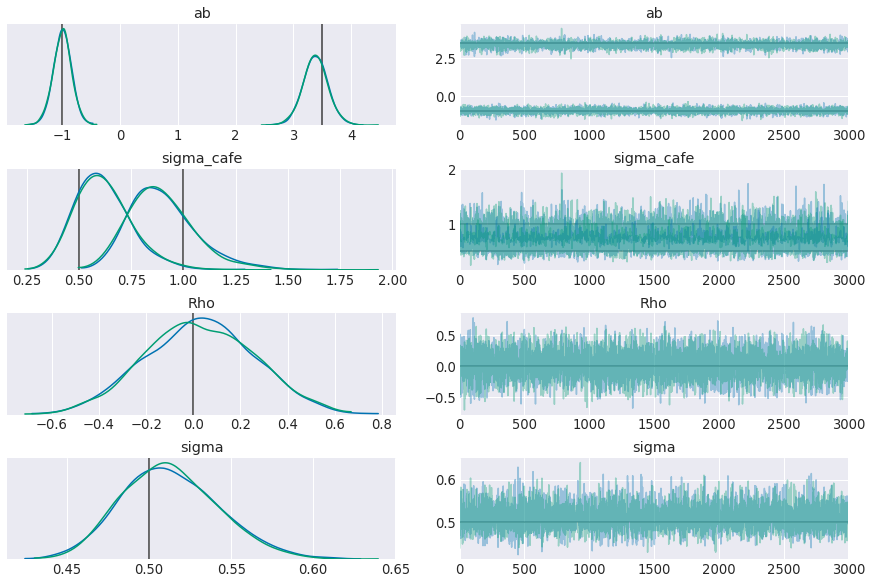

In [9]:
az.plot_trace(trace_cafe, var_names=["ab", "sigma_cafe", "Rho", "sigma"], compact=True,
              lines=[("ab", {}, Mu),
                     ("sigma_cafe", {}, [sigma_a, sigma_b]),
                     ("Rho", {}, rho),
                     ("sigma", {}, sigma)
                    ]
             );

There’s the zero correlation. If you changed the numpy random seed we set at the beginning of this notebook, your posterior distributions might look different. This is a good reminder that any particular sample may be misleading. The posterior distribution is not magic: it cannot necessarily recover the data-generating mechanism. And with real data, these models will never accurately recover the data-generating mechanism. At best, they describe it in a scientifically useful way.

### 13M2.
*Fit this multilevel model to the simulated café data from the chapter:*

$W_{i} \sim Normal(\mu_{i}, \sigma)$

$\mu_{i} = \alpha_{CAFE[i]} + \beta_{CAFE[i]} A_{i}$

$\alpha_{CAFE} \sim Normal(\alpha, \sigma_{\alpha})$

$\beta_{CAFE} \sim Normal(\beta, \sigma_{\beta})$

$\alpha, \beta \sim Normal(0, 10)$

$\sigma_{\alpha}, \sigma_{\beta}, \sigma \sim HalfCauchy(1)$

*Use WAIC to compare this model to the model from the chapter, the one that uses a multi-variate Gaussian prior. Explain the result*

The model presented here uses completely independent priors for the intercepts, $\alpha_{CAFE}$, and slopes, $\beta_{CAFE}$. The consequence of this is that the model implicitly assumes no correlation between the intercepts and slopes. It’s missing the correlation parameter. Let’s see what happens when in truth the intercepts and slopes are indeed correlated but the model ignores the correlation. First, let’s run the data simulation again:

In [10]:
# set up parameters of population
a = 3.5        # average morning wait time
b = -1.        # average difference afternoon wait time
sigma_a = 1.   # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7     # correlation between intercepts and slopes

Mu = [a, b]
cov_ab = sigma_a * sigma_b * rho
Sigma = np.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])

# simulate observations
N_cafes = 20
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_cafes)
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

N_visits = 10
afternoon = np.tile([0,1], N_visits * N_cafes//2)
cafe_id = np.repeat(np.arange(N_cafes), N_visits)

mu = a_cafe[cafe_id] + b_cafe[cafe_id]*afternoon
sigma = 0.5 # std dev within cafes
wait = np.random.normal(loc=mu, scale=sigma, size=N_visits*N_cafes)

# package into dataframe
d = pd.DataFrame(dict(cafe=cafe_id , afternoon=afternoon , wait=wait))
d.head(11)

,cafe,afternoon,wait
0,0,0,3.317183
1,0,1,1.523319
2,0,0,3.714468
3,0,1,3.157131
4,0,0,3.077140
5,0,1,1.576000
6,0,0,3.516237
7,0,1,2.402456
8,0,0,3.211313
9,0,1,1.745291


And here is the code to sample from the new model’s posterior distribution:

In [11]:
with pm.Model() as m13M2:
    a = pm.Normal("a", 0., 10.)
    b = pm.Normal("b", 0., 10.)
    sigma_a = pm.Exponential("sigma_a", 1.)
    sigma_b = pm.Exponential("sigma_b", 1.)
    
    a_cafe = pm.Normal('a_cafe', a, sigma_a, shape=N_cafes)
    b_cafe = pm.Normal('b_cafe', b, sigma_b, shape=N_cafes)
        
    mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
    sd = pm.Exponential("sigma", 1.)
    
    w = pm.Normal("w", mu, sd, observed=d.wait.values)

    trace_m13M2 = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_cafe, a_cafe, sigma_b, sigma_a, b, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:30<00:00, 197.65draws/s]


And let’s sample again from the model in the chapter, so we can directly compare estimates. Instead of re-coding everything, we can just fit the model m_cafe from problem 13M1 to the new correlated café data, as this is the same model as in the chapter:

In [12]:
with m_cafe:
    pm.set_data({"wait_data": d.wait})
    trace_mv = pm.sample(3000, tune=3000, cores=2, random_seed=RANDOM_SEED, nuts_kwargs={"target_accept": .9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ab_cafe, ab, chol_cov]
Sampling 2 chains: 100%|██████████| 12000/12000 [04:11<00:00, 47.79draws/s]


We’re primarily interested in differences in the varying effects estimates. So let’s plot them together and see if there are any differences (in posterior means):

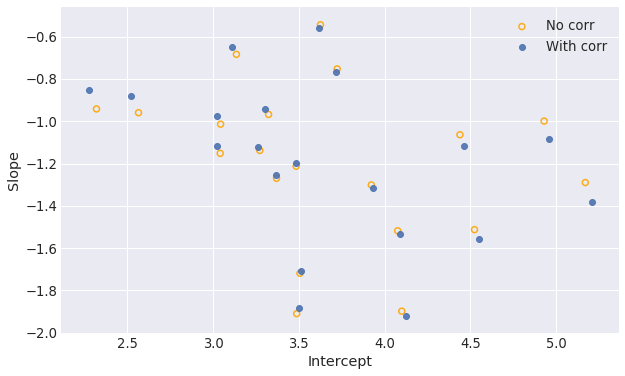

In [13]:
post_m13M2 = pm.trace_to_dataframe(trace_m13M2)
post_mv = pm.trace_to_dataframe(trace_mv)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(N_cafes):
    no_corr = ax.scatter(post_m13M2[f"a_cafe__{i}"].mean(), post_m13M2[f"b_cafe__{i}"].mean(),
                         alpha=0.9, facecolors="none", edgecolors="orange", linewidths=1.5)
    corr = ax.scatter(post_mv[f"ab_cafe__{i}_0"].mean(), post_mv[f"ab_cafe__{i}_1"].mean(), 
                      alpha=0.9, color="b")

plt.xlabel("Intercept")
plt.ylabel("Slope")
plt.legend([no_corr, corr], ["No corr", "With corr"]);

The blue filled points are the posterior means from m_cafe, the original model in the chapter that includes the correlation between intercepts and slopes. The open points are the posterior means from m13M2, the model that assumes no correlation between intercepts and slopes.

First, notice that there is a lot of agreement here. Assuming no correlation didn’t completely change inference. And if you look at the posterior distributions of the average effects ($\alpha$ and $\beta$) and the standard deviation parameters, they are essentially identical:

In [14]:
# No corr model
az.summary(trace_m13M2, var_names=["a", "b", "sigma_a", "sigma_b"], credible_interval=0.89, round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,3.65,0.19,3.36,3.94,0.0,0.0,2240.68,2237.28,2267.32,1477.50,1.0
b,-1.19,0.13,-1.43,-1.01,0.0,0.0,2294.35,2294.35,2304.34,1493.82,1.0
sigma_a,0.79,0.15,0.56,1.01,0.0,0.0,2127.02,2002.34,2199.85,1089.20,1.0
sigma_b,0.48,0.12,0.29,0.67,0.0,0.0,1148.21,1148.21,1088.10,1085.71,1.0


In [15]:
# With corr model
az.summary(trace_mv, var_names=["ab", "sigma_cafe"], credible_interval=0.89, round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ab[0],3.65,0.19,3.34,3.95,0.0,0.0,6428.00,6415.22,6419.17,4202.76,1.0
ab[1],-1.19,0.13,-1.39,-0.97,0.0,0.0,5615.10,5562.24,5643.16,5262.43,1.0
sigma_cafe[0],0.80,0.14,0.59,1.03,0.0,0.0,6987.36,6325.34,7674.17,4501.14,1.0
sigma_cafe[1],0.48,0.12,0.28,0.66,0.0,0.0,3399.21,3399.21,3243.10,2681.15,1.0


Second, notice that there are differences in the above plot, and they tend to occur at extreme intercept and slope values. In the middle of the cloud of points, the blue and open circles almost perfectly overlap. At the edges, there is more separation. This is especially true for extreme intercepts. What’s going on here?

Model m_cafe estimated the correlation between intercepts and slopes and used that correlation at the same time to adjust the intercepts and slopes. You learned this much in the chapter. The correlation in these data is negative, so large intercepts are associated (on average) with small slopes. So in the plot above, right of the center the blue points are displaced *below* the open points, because the model used the fact that those intercepts were *larger* than average to push the slopes to be *smaller*. Likewise, to the left of the center, the intercepts are *smaller* than average. So the model pushes the slopes up to become *larger*.

The model that includes the correlation will be, on average, more accurate. It exploits additional information about the population in order to shrink in both dimensions.

### 13M3.
*Re-estimate the varying slopes model for the UCBadmit data, now using a non-centered parametrization. Compare the efficiency of the forms of the model, using n_eff. Which is better? Which chain sampled faster?*

In [16]:
d_ad = pd.read_csv('../Data/UCBadmit.csv', sep=';')
d_ad['male'] = (d_ad['applicant.gender'] == 'male').astype(int)
d_ad['dept_id'] = pd.Categorical(d_ad['dept']).codes
d_ad

,dept,applicant.gender,admit,reject,applications,male,dept_id
1,A,male,512,313,825,1,0
2,A,female,89,19,108,0,0
3,B,male,353,207,560,1,1
4,B,female,17,8,25,0,1
5,C,male,120,205,325,1,2
6,C,female,202,391,593,0,2
7,D,male,138,279,417,1,3
8,D,female,131,244,375,0,3
9,E,male,53,138,191,1,4
10,E,female,94,299,393,0,4


In [17]:
Dept_id = d_ad['dept_id'].values
Ndept = len(d_ad['dept_id'].unique())

with pm.Model() as m_ucb:
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.math.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_dept', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    a = pm.Normal('a', 0., 10.)
    bm = pm.Normal('bm', 0., 1.)
    mu = pm.MvNormal('ab_dept', mu=tt.stack([a, bm]), chol=chol, shape=(Ndept, 2))
    
    a_dept = pm.Deterministic('a_dept', mu[:, 0])
    bm_dept = pm.Deterministic('bm_dept', mu[:, 1])
    
    p = pm.math.invlogit(mu[Dept_id, 0] + mu[Dept_id, 1] * d_ad['male'])
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_ucb = pm.sample(3000, tune=3000, cores=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ab_dept, bm, a, chol_cov]
Sampling 2 chains: 100%|██████████| 12000/12000 [03:40<00:00, 54.40draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [18]:
with pm.Model() as m_ucb_nc:
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.math.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_dept', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    a = pm.Normal('a', 0., 10.)
    bm = pm.Normal('bm', 0., 1.)
    mu = pm.MvNormal('ab_dept', mu=tt.stack([0., 0.]), chol=chol, shape=(Ndept, 2))
    
    a_dept = pm.Deterministic('a_dept', mu[:, 0])
    bm_dept = pm.Deterministic('bm_dept', mu[:, 1])
    
    p = pm.math.invlogit(a + mu[Dept_id, 0] + (bm + mu[Dept_id, 1]) * d_ad['male'])
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_ucb_nc = pm.sample(3000, tune=3000, cores=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ab_dept, bm, a, chol_cov]
Sampling 2 chains: 100%|██████████| 12000/12000 [11:46<00:00, 12.69draws/s]
The acceptance probability does not match the target. It is 0.6644759116045177, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


First let’s compare running times. On my machine, the original model, m_ucb, took about 3:30 minutes. The new model, m_ucb_nc, took about 12 minutes to finish sampling. So the centered version of the model, m_ucb, sampled faster. Now let’s compare effective sample sizes:

In [19]:
sum_c = az.summary(trace_ucb, credible_interval=0.89, round_to=2,
                   var_names=["a", "bm", "a_dept", "bm_dept", "sigma_dept", "Rho"])["ess_mean"]
sum_nc = az.summary(trace_ucb_nc, credible_interval=0.89, round_to=2,
                    var_names=["a", "bm", "a_dept", "bm_dept", "sigma_dept", "Rho"])["ess_mean"]

comp = pd.concat([sum_c, sum_nc], axis=1)
comp.columns = ["ess_mean_c", "ess_mean_nc"]
comp["diff"] = comp.ess_mean_c - comp.ess_mean_nc
comp.round()

,ess_mean_c,ess_mean_nc,diff
a,3258.0,826.0,2433.0
bm,4015.0,1384.0,2631.0
a_dept[0],3044.0,885.0,2159.0
a_dept[1],3650.0,947.0,2703.0
a_dept[2],5538.0,834.0,4704.0
a_dept[3],5389.0,839.0,4550.0
a_dept[4],6370.0,836.0,5534.0
a_dept[5],4742.0,873.0,3869.0
bm_dept[0],2948.0,2075.0,873.0
bm_dept[1],3611.0,2461.0,1151.0


Wow, the centered version actually has higher effective sample sizes! But in the text, I said that non-centered parameterizations were good for getting more efficient sampling... What is going on here?

The truth is that the chapter says that *sometime*s non-centered parameterizations are better. Other times, the centered form is better. This is such a time. How can you guess which situation you are in, before trying both parameterizations? Typically you can’t. But the non-centered parameterization tends to be better when the variation across clusters is either very small — close to zero — or poorly identified by the data.

### 13M4.
*Use WAIC to compare the Gaussian process model of Oceanic tools to the models fit to the same data in chapter 10. Pay special attention to the effective number of parameters, as estimated by WAIC.*

In [20]:
dk = pd.read_csv('../Data/Kline2.csv', sep=",")
Nsociety = dk.shape[0]
dk.loc[:, 'society'] = np.arange(Nsociety)
dk["contact_high"] = (dk.contact == "high").astype(int)

Dmat = pd.read_csv('../Data/islandsDistMatrix.csv', sep=",", index_col=0)
Dmat_ = Dmat.values
Dmatsq = np.power(Dmat_, 2)

In [21]:
with pm.Model() as m_13_7:
    etasq = pm.HalfCauchy('etasq', 1.)
    rhosq = pm.HalfCauchy('rhosq', 1.)
    Kij = etasq*(tt.exp(-rhosq*Dmatsq)+np.diag([.01]*Nsociety))
    
    g = pm.MvNormal('g', mu=np.zeros(Nsociety), cov=Kij, shape=Nsociety)
    a = pm.Normal('a', 0., 10.)
    bp = pm.Normal('bp', 0., 1.)
    
    lam = pm.math.exp(a + g[dk.society.values] + bp*dk.logpop)
    
    obs = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    
    trace_13_7 = pm.sample(3000, tune=3000, cores=2, random_seed=RANDOM_SEED, nuts_kwargs={"target_accept": .95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bp, a, g, rhosq, etasq]
Sampling 2 chains: 100%|██████████| 12000/12000 [16:07<00:00, 12.40draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [22]:
with pm.Model() as m_10_10:
    a = pm.Normal('a', 0., 10.)
    b = pm.Normal('b', 0., 1., shape=3)
    
    lam = pm.math.exp(a + b[0]*dk.logpop + b[1]*dk.contact_high + b[2]*dk.contact_high*dk.logpop)
    
    obs = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    
    trace_10_10 = pm.sample(3000, tune=3000, cores=2, random_seed=RANDOM_SEED)
    
with pm.Model() as m_10_11:
    a = pm.Normal('a', 0., 10.)
    b = pm.Normal('b', 0., 1., shape=2)
    
    lam = pm.math.exp(a + b[0]*dk.logpop + b[1]*dk.contact_high)
    
    obs = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    
    trace_10_11 = pm.sample(3000, tune=3000, cores=2, random_seed=RANDOM_SEED)
    
with pm.Model() as m_10_12:
    a = pm.Normal('a', 0., 10.)
    b = pm.Normal('b', 0., 1.)
    
    lam = pm.math.exp(a + b*dk.logpop)
    
    obs = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    
    trace_10_12 = pm.sample(3000, tune=3000, cores=2, random_seed=RANDOM_SEED)
    
with pm.Model() as m_10_13:
    a = pm.Normal('a', 0., 10.)
    b = pm.Normal('b', 0., 1.)
    
    lam = pm.math.exp(a + b*dk.contact_high)
    
    obs = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    
    trace_10_13 = pm.sample(3000, tune=3000, cores=2, random_seed=RANDOM_SEED)
    
with pm.Model() as m_10_14:
    a = pm.Normal('a', 0., 10.)
    
    lam = pm.math.exp(a)
    
    obs = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    
    trace_10_14 = pm.sample(3000, tune=3000, cores=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains: 100%|██████████| 12000/12000 [01:41<00:00, 117.99draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:58<00:00, 206.52draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:34<00:00, 233.70draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:19<00:00, 622.46draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sa

Now let’s compare them all using WAIC:

In [23]:
traces = [trace_10_10, trace_10_11, trace_10_12, trace_10_13, trace_10_14, trace_13_7]
model_names = ['m10.10', 'm10.11', 'm10.12', 'm10.13', 'm10.14', 'm13.7']
comp = az.compare(dict(zip(model_names, traces)))
comp

/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1078: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1078: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1078: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """
/anaconda/envs/stat-rethink-pym

,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m13.7,67.3699,3.99054,0,0.848744,41.5945,0,True,deviance
m10.11,78.8846,4.11999,11.5147,0.0891265,10.8449,10.8558,True,deviance
m10.10,80.2568,4.94535,12.8869,0.0553861,2.04068,10.9213,True,deviance
m10.12,84.2153,3.61201,16.8454,0.00660095,11.0633,7.65569,True,deviance
m10.14,141.766,8.37761,74.3956,2.70898e-06,29.0688,30.9639,True,deviance
m10.13,150.56,16.6319,83.1896,0.000139912,8.43932,44.375,True,deviance


The Gaussian process model, m13.7, gets nearly all of the weight. However, the standard error of the difference between it and the next highest ranked model, m10.11, is the same as the difference itself. And the next ranked model, m10.10, is basically tied with m10.11. So we can’t be too cocky here. There isn’t a lot of data, after all.

But we can still learn from attempting to understand the effective number of parameter, p_WAIC, as the problem asks. Model m13.7 has 4 parameters, and WAIC estimates its effective parameter count at almost exactly 4. You might think this is to be expected, but look at the other models. Here’s a table comparing each model's actual parameter count and the effective parameter count:

In [24]:
parameters = pd.Series({'m10.10': 4, 'm10.11': 3, 'm10.12': 2, 'm10.13': 2, 'm10.14': 1, 'm13.7': 4}, name="parameters")
pd.concat([parameters, comp.p_waic], axis=1, sort=False)

,parameters,p_waic
m10.10,4,4.94535
m10.11,3,4.11999
m10.12,2,3.61201
m10.13,2,16.6319
m10.14,1,8.37761
m13.7,4,3.99054


There’s a tendency for the other Poisson models to be more flexible than you might expect from the parameter count alone. Model 10.14, the intercept-only model, actually ends up with almost 7 more effective parameters than actual parameters. And model m10.13 ends up with a whopping 17 effective parameters.

This is in fact a very common occurrence with Poisson GLMs. So do not be alarmed. For now, just note that the Gaussian process model is the only model here with any form of adaptive regularization. It is a very complex model, based upon its structure, but it is actually less flexible than most of the other models, and it is the only model that has about the same number of effective parameters as actual parameters.

### 13H1.
*Let's revisit the Bangladesh fertility data, bangladesh.csv, from the practice problems for chapter 12. Fit a model with both varying intercept by district_id and varying slopes of urban by district_id. You are still predicting $use.contraception$.*

*Inspect the correlation between the intercepts and slopes. Can you interpret this correlation, in terms of what it tells you about the pattern of contraceptive use in the sample? It might help to plot the mean (or median) varying effect estimates for both the intercepts and slopes, by district. Then you can vizualise the correlation and maybe more easily think through what it means to have a particular correlation. Plotting predicted proportion of women on one axis and rural on the other might also help.*

Let's begin by loading the data. As in chapter 12, district 54 is absent from the dataset. So $district$ isn’t yet a good index variable, because it’s not contiguous. This is easy to fix. Just make a new variable that is contiguous:

In [25]:
d = pd.read_csv('../Data/bangladesh.csv', sep=";")

d["district_id"], _ = pd.factorize(d.district, sort=True)
district_id = d.district_id.values
Ndistricts = len(d.district_id.unique())

d.head()

,woman,district,use.contraception,living.children,age.centered,urban,district_id
0,1,1,0,4,18.4400,1,0
1,2,1,0,1,-5.5599,1,0
2,3,1,0,3,1.4400,1,0
3,4,1,0,4,8.4400,1,0
4,5,1,0,1,-13.5590,1,0


In [26]:
with pm.Model() as m_13H1:
    sd_dist = pm.Exponential.dist(1)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.math.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_district', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    a = pm.Normal('a', 0., 10.)
    bu = pm.Normal('bu', 0., 1.)
    mu = pm.MvNormal('ab_district', mu=tt.stack([a, bu]), chol=chol, shape=(Ndistricts, 2))
    
    a_district = pm.Deterministic('a_district', mu[:, 0])
    bu_district = pm.Deterministic('bu_district', mu[:, 1])
    
    p = pm.math.invlogit(mu[district_id, 0] + mu[district_id, 1]*d["urban"])
    
    used = pm.Bernoulli('used', p=p, observed=d["use.contraception"])
    
    trace_13H1 = pm.sample(2000, tune=4000, cores=2, random_seed=RANDOM_SEED, nuts_kwargs={"target_accept": .9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ab_district, bu, a, chol_cov]
Sampling 2 chains: 100%|██████████| 12000/12000 [10:02<00:00, 12.73draws/s]
The number of effective samples is smaller than 25% for some parameters.


Let’s look at the marginal posterior, omitting the varying effects:

In [27]:
az.summary(trace_13H1, var_names=["a", "bu", "sigma_district", "Rho"], credible_interval=0.89, round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.71,0.10,-0.86,-0.54,0.00,0.00,3837.13,3837.13,3842.40,3172.78,1.00
bu,0.70,0.17,0.44,0.96,0.00,0.00,2691.14,2691.14,2686.75,2851.51,1.00
sigma_district[0],0.58,0.10,0.42,0.73,0.00,0.00,1289.83,1289.83,1252.69,1507.86,1.00
sigma_district[1],0.79,0.19,0.48,1.10,0.01,0.01,713.11,713.11,698.60,991.13,1.00
Rho[0],-0.66,0.16,-0.89,-0.43,0.01,0.00,814.74,814.74,807.07,1619.88,1.01


So the main effect of urban residence appears to be to increase contraceptive use. Not too surprising. From the variance components, sigma_district[0] is the standard deviation for varying intercepts and sigma_district[1] is the standard deviation for slopes. We see that there is more variation in the slope of urban across districts than there is in the intercepts. We do have to be careful interpreting differences here, because a varying slope is multiplied by data, so the scale isn’t the same as the intercepts. But it’s safe to say that there’s a lot of variation in slopes — urbanity has a different relationship with contraceptive use in different districts.

Now let’s inspect the correlation between intercepts and slopes across districts. The posterior mean of $\rho$ is −0.66, with an 89% interval well below zero. Here’s the marginal posterior for $\rho$, the correlation between intercepts and slopes in the population of districts:

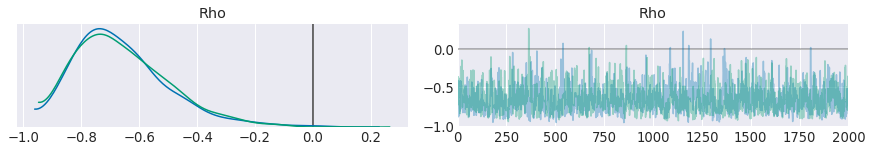

In [28]:
az.plot_trace(trace_13H1, var_names=["Rho"], lines=[("Rho", {}, 0.)], compact=True);

All of this means that intercepts and slopes are negatively correlated. So larger intercepts are paired with smaller slopes. The higher the contraceptive use in rural areas (determined entirely by the varying intercept), the smaller the difference with the urban areas of the same district. This is easier to see with two more plots. Let’s show probability of rural use against probability of urban use for each
district, as well as the difference between urban and rural, as a function of rural use:

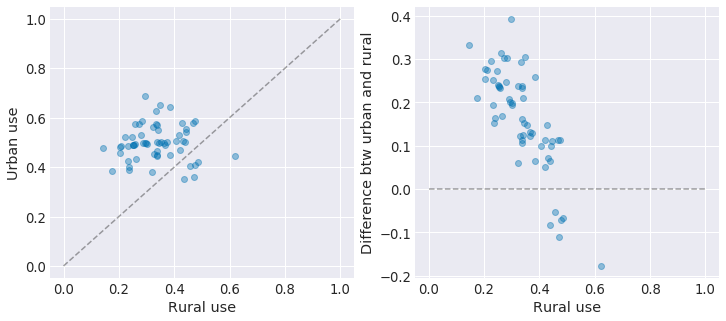

In [29]:
# Extract varying effets
post_13H1 = pm.trace_to_dataframe(trace_13H1)

var_intercepts = post_13H1[[col for col in post_13H1.columns if col.startswith("a_district")]]
mean_var_intercepts = var_intercepts.mean().reset_index(drop=True)
var_slopes = post_13H1[[col for col in post_13H1.columns if col.startswith("bu_district")]]
mean_var_slopes = var_slopes.mean().reset_index(drop=True)

p_mean_rural = sp.special.expit(mean_var_intercepts)
p_mean_urban = sp.special.expit(mean_var_intercepts + mean_var_slopes)

# Plot!
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(p_mean_rural, p_mean_urban, "o", ms=6, alpha=.4)
ax1.plot([0., 1.], [0., 1.], "k--", alpha=.4)
ax1.set_xlabel("Rural use")
ax1.set_ylabel("Urban use")

ax2.plot(p_mean_rural, p_mean_urban - p_mean_rural, "o", ms=6, alpha=.4)
ax2.hlines(0., 0., 1., linestyles="dashed", alpha=.4)
ax2.set_xlabel("Rural use")
ax2.set_ylabel("Difference btw urban and rural");

So we might say that districts in which more rural women use contraception have urban areas more similar to the rural areas. To say it another way, districts in which rural women use more contraception are places in which the urban and rural women are more similar (closer to the dashed lines). Districts in which urban use is highest have low rural use, but districts with the lowest urban use rates have some of the highest rural use rates.

### 13H2.
*Varying effects models are useful for modeling time series, as well as spatial clustering. In a time series, the observations cluster by entities that have continuity through time, such as individuals. Since observations within individuals are likely highly correlated, the multilevel structure can help quite a lot. You'll use the data in oxboys.csv, which are 234 height measurements on 26 boys from an Oxford Boys Club (I think these were like youth athletic leagues?), at 9 different ages (centered and standardized) per boy. You'll be interested in predicting height, using age, clustered by Subject (individual boy).*

*Fit a model with varying intercepts and slopes (on age), clustered by Subject. Present and interpret the parameter estimates. Which varying effect contributes more variation to the heights, the intercept or the slope?*

In [30]:
d = pd.read_csv("../Data/oxboys.csv", sep=";")
d["Subject"] = d.Subject - 1 # 0-indexing
subject_id = d.Subject.values
Nsubjects = len(d.Subject.unique())
d.head()

,Subject,age,height,Occasion
0,0,-1.0000,140.5,1
1,0,-0.7479,143.4,2
2,0,-0.4630,144.8,3
3,0,-0.1643,147.1,4
4,0,-0.0027,147.7,5


In [31]:
with pm.Model() as m_oxboys:
    sd_dist = pm.HalfCauchy.dist(beta=1.)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.math.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_subject', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    a = pm.Normal('a', d["height"].mean(), 50.)
    bA = pm.Normal('bA', 0., 30.)
    ab_subject = pm.MvNormal('ab_subject', mu=tt.stack([a, bA]), chol=chol, shape=(Nsubjects, 2))
    
    a_subject = pm.Deterministic('a_subject', ab_subject[:, 0])
    bA_subject = pm.Deterministic('bA_subject', ab_subject[:, 1])
    
    mu = a_subject[subject_id] + bA_subject[subject_id]*d["age"]
    sigma = pm.HalfCauchy("sigma", 1.)
    
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    
    h = pm.Normal('h', mu=mu, sigma=sigma, observed=d["height"])
    
    trace_oxboys = pm.sample(2000, tune=2000, cores=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ab_subject, bA, a, chol_cov]
Sampling 2 chains: 100%|██████████| 8000/8000 [01:04<00:00, 124.26draws/s]


Let’s do some prior predictive checks, to see if our prior choice makes sense:

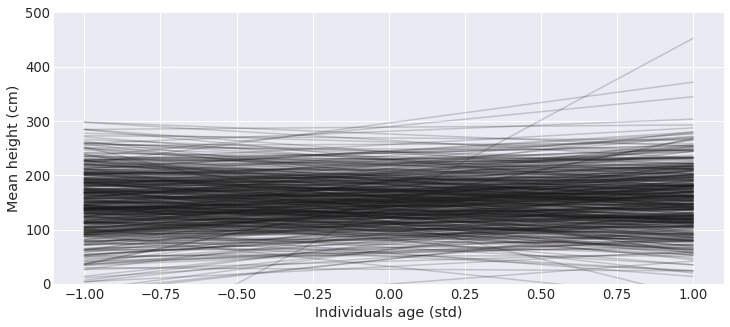

In [32]:
plt.figure(figsize=(12,5))

for y in zip(prior_checks["a_subject"] - prior_checks["bA_subject"], prior_checks["a_subject"] + prior_checks["bA_subject"]):
    plt.plot([-1, 1], y, color='k', alpha=.2)

plt.xlabel("Individuals age (std)")
plt.ylabel("Mean height (cm)")
plt.ylim([-1, 500]);

We see that these priors are not very regularizing: there are some absurd growth patterns - people growing very quickly to unimaginable heights, at least on this Earth (more than 500 cm), or even people downsizing with age. However, we also see that the bulk of prior outcomes stays in the realm of the possible, so should allow the model to learn the patterns of the dataset.

Now, let’s look at the estimates, omitting the varying effects and the population correlation for the moment:

In [33]:
az.summary(trace_oxboys, var_names=["a", "bA", "sigma_subject"], credible_interval=0.89, round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,149.38,1.57,146.96,151.91,0.02,0.02,4860.35,4851.36,4879.95,3122.14,1.0
bA,6.53,0.33,5.96,7.02,0.00,0.00,4794.03,4710.71,4894.91,3180.43,1.0
sigma_subject[0],8.03,1.13,6.25,9.73,0.02,0.01,4315.55,4019.89,4639.64,2911.49,1.0
sigma_subject[1],1.67,0.24,1.30,2.04,0.00,0.00,4236.05,3838.77,4664.42,2941.29,1.0


Let’s interpret the intercept $a$ first. Since the predictor, $age$, is standardized, the intercept is the average height at the average age. Then the average slope $b$ is the average change in height for a unit change in standard age. So over the whole sample, which is about 2 units of standard age, the average boy grew about $2 × 6.5 = 13 cm$. That’s not so easy to understand. Plotting the raw data might help:

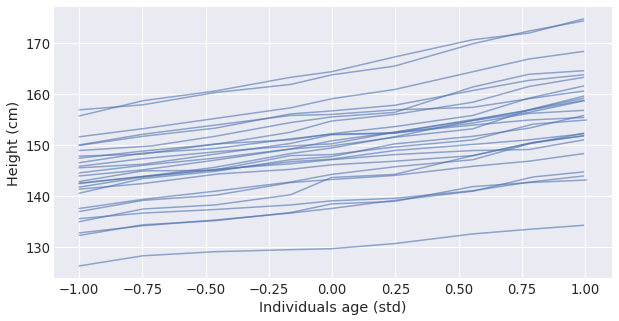

In [34]:
plt.figure(figsize=(10,5))

for i in range(Nsubjects):
    plt.plot(d.loc[d.Subject == i, "age"], d.loc[d.Subject == i, "height"], color='b', alpha=.6)

plt.xlabel("Individuals age (std)")
plt.ylabel("Height (cm)");

You can see here perhaps (if not, just stare at it like it was a beautiful painting) that while some boys grew more and others grew less, the average growth was a little more than 10 cm.

Let’s consider the variation in intercepts and slopes now, as the problem asks. There is substantial variation among both intercepts (8.03 on average, see the summary dataframe above) and slopes (1.67). But which contributes more to variation in the data? You can’t really say without knowing the predictor values that multiply the slopes. If for example the age values have a very large range in the data, then even a smaller standard deviation for slopes could manifest as more variation in the data attributable to variation in slopes. But in this case, you can probably appreciate from the plot just above that the intercepts are contributing more to differences among boys in the total data. Indeed, the slopes are quite mild, while the intercepts differ a lot. This is consistent with the higher variation in intercepts than slopes picked up by the model.

### 13H3.
*Now consider the correlation between the varying intercepts and slopes. Can you explain its value? How would this estimated correlation influence your predictions about a new sample of boys?*

In [35]:
az.summary(trace_oxboys, var_names=["Rho"], credible_interval=0.89, round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Rho[0],0.55,0.13,0.34,0.75,0.0,0.0,5094.37,4985.36,5052.35,3221.59,1.0


So the posterior distribution of the correlation between intercepts and slopes has a mean of 0.55 and an 89% interval from 0.34 to 0.75. This is what it looks like:

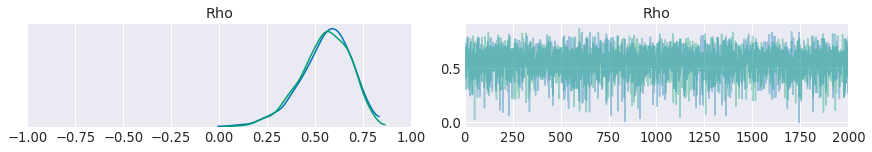

In [36]:
axes = az.plot_trace(trace_oxboys, var_names=["Rho"], compact=True)
axes[0, 0].set_xlim([-1, 1]);

This positive correlation suggests that larger intercepts are associated with larger slopes. In more meaningful terms, this means that boys who are bigger also grow faster - this is an illustration of what we said in problem 13E2. You might be able to see this in the data plot from the previous problem: the boys who were tallest at the start also grew the fastest; the boys who were shortest at the start also grew the slowest. As a result, the difference between the tallest and shortest boys grew over time.

To appreciate the value of this inference, consider a new sample of boys that is purely cross-sectional - no time series has yet been observed. But on the basis of this correlation, you might predict that the tallest boys in the new sample would grow the fastest. This would let you make better predictions, assuming of course that this result generalizes to another sample.

### 13H4.
*Simulate a new sample of boys, based upon the posterior mean values of the parameters. That is, try to simulate varying intercepts and slopes, using the relevant paremeter estimates, and then plot the predicted trends of height on age, one trend for each simulated boy you produce. A sample of 10 simulated boys is plenty to illustrate the lesson. You can ignore uncertainty in the posterior, just to make the problem a little easier. But if you want to include the uncertainty about the parameters, go for it.*

To simulate, you just run the model forwards. So we extract the estimates of the parameters and use them to define a distribution. Then we sample random values from that distribution. I’ll walk through each step.

First, it will help to write down the varying intercepts and slopes model in math form, for clarity:

$H_{i} \sim Normal(\mu_{i}, \sigma)$

$\mu_{i} = \alpha_{SUBJECT[i]} + \beta_{SUBJECT[i]} A_{i}$

$\begin{bmatrix} \alpha_{SUBJECT} \\ \beta_{SUBJECT} \end{bmatrix} \sim MvNormal(\begin{bmatrix} \alpha \\ \beta \end{bmatrix},
                                                                                \begin{pmatrix} \sigma_{\alpha}^2
                                                                                                & \sigma_{\alpha} \sigma_{\beta} \rho
                                                                                                \\ \sigma_{\alpha} \sigma_{\beta} \rho
                                                                                                & \sigma_{\beta}^2
                                                                                \end{pmatrix})$
                                                                                
So $H_{i}$ is the height for observation i, $A_{i}$ is the corresponding age for that case. $\sigma$ defines the standard deviation of heights for a particular Subject and age combination (this is mostly going to be measurement error, but could also be changes across ages that don’t correspond to the linear trend that is being modeled). $\alpha$ is the average height at age zero across all boys, and $\beta$ is the average slope on age, across all boys. The varying effects $\alpha_{SUBJECT}$ and $\beta_{SUBJECT}$ are the individual Subject deviations from those averages. And finally we assume those varying effects are sampled from a bivariate normal distribution (last line of the model above), with a covariance matrix like:

$S = \begin{pmatrix} 
        \sigma_{\alpha}^2 & \sigma_{\alpha} \sigma_{\beta} \rho
        \\ \sigma_{\alpha} \sigma_{\beta} \rho & \sigma_{\beta}^2 
     \end{pmatrix}$
     
Three parameters define the covariance matrix: the standard deviation of intercepts ($\sigma_{\alpha}$), the standard deviation of slopes ($\sigma_{\beta}$), and the correlation between intercepts and slopes ($\rho$).
So to simulate boys from the fit model, we need estimates for $\alpha$, $\beta$, $\sigma$, $\sigma_{\alpha}$, $\sigma_{\beta}$, and $\rho$. We don’t need to pay attention to the $\alpha_{SUBJECT}$ and $\beta_{SUBJECT}$ estimates, because we are simulating new boys, not plotting predictions for the boys in the sample. So make some symbols to hold the posterior means (ignoring uncertainty for the moment):

In [37]:
post_oxboys = pm.trace_to_dataframe(trace_oxboys)

a_avg = post_oxboys["a"].mean() # average height
bA_avg = post_oxboys["bA"].mean() # average change in height for a unit change in age
Mu = [a_avg, bA_avg]

sigma_a = post_oxboys["sigma_subject__0"].mean() # std dev in intercepts
sigma_b = post_oxboys["sigma_subject__1"].mean() # std dev in slopes
rho = post_oxboys["Rho__0"].mean() # correlation between intercepts and slopes
cov_ab = sigma_a * sigma_b * rho
Sigma = np.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]]) # covariance matrix
Sigma

array([[64.51721698,  7.3751377 ],
       [ 7.3751377 ,  2.79503508]])

And now to sample varying intercepts and slopes from the bivariate distribution of them:

In [38]:
N_boys = 10
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_boys)
a_ind = vary_effects[:, 0]
bA_ind = vary_effects[:, 1]
vary_effects

array([[159.40560646,  10.10344608],
       [151.1489968 ,   7.12171371],
       [135.36435828,   4.39081068],
       [156.75559029,   7.97782304],
       [148.12913308,   7.96316241],
       [157.42467565,   6.45341897],
       [151.14707619,   2.7217669 ],
       [144.10107937,   7.31499316],
       [145.34041391,   5.57794158],
       [142.12336325,   6.38425128]])

Those are 10 random boys, with their own varying intercepts (first column) and slopes (second column). 

Now the last simulation step is to top it all off with a simulated trend for each boy. So now we make use of $\sigma$ and produce random normal heights across ages. We'll simulate 9 heights for each boy.

In [39]:
N_measures = 9 # nbr observations per boy
age_seq = np.tile(np.linspace(-1, 1, N_measures), N_boys) # each boy observed at 9 different ages
ind_id = np.repeat(np.arange(N_boys), N_measures)

mu_ind = a_ind[ind_id] + bA_ind[ind_id]*age_seq # mean height for each boy, at different ages
sigma_avg = post_oxboys["sigma"].mean() # std dev within boys
heights = np.random.normal(loc=mu_ind, scale=sigma_avg, size=N_boys*N_measures)

post_pred = pd.DataFrame(dict(ind=ind_id, age=age_seq, height=heights))
post_pred.head()

,ind,age,height
0,0,-1.00,149.227672
1,0,-0.75,151.138338
2,0,-0.50,154.806653
3,0,-0.25,158.358380
4,0,0.00,159.012544


Finally, here’s what it looks like:

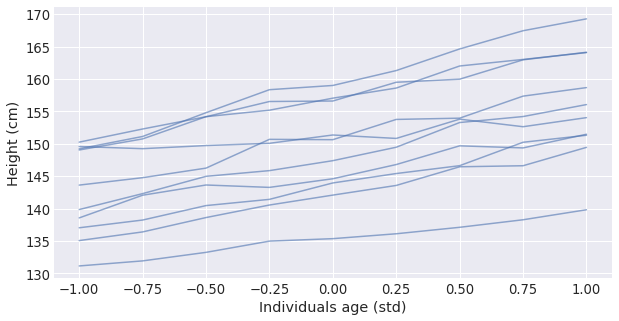

In [40]:
plt.figure(figsize=(10,5))

for i in range(N_boys):
    plt.plot(post_pred.loc[post_pred.ind == i, "age"], post_pred.loc[post_pred.ind == i, "height"], color='b', alpha=.6)

plt.xlabel("Individuals age (std)")
plt.ylabel("Height (cm)");

As always, your plot will look a little different, on account of simulation variance. Run the simulation a few times to get a sense for this.

In [41]:
import sys, IPython, scipy, matplotlib, platform
print(f"This notebook was created on a computer {platform.machine()}, using: "
      f"\nPython {sys.version[:5]}\nIPython {IPython.__version__}\nPyMC3 {pm.__version__}\nArviz {az.__version__}\nNumPy {np.__version__}"
      f"\nPandas {pd.__version__}\nSciPy {scipy.__version__}\nMatplotlib {matplotlib.__version__}\n")

This notebook was created on a computer x86_64, using: 
Python 3.7.3
IPython 7.5.0
PyMC3 3.7
Arviz 0.4.1
NumPy 1.16.3
Pandas 0.24.2
SciPy 1.2.1
Matplotlib 3.0.3

